In [1]:
import pandas as pd
import os
import re
from dataclasses import dataclass
import json
%matplotlib inline

In [2]:
jobname_regex = re.compile(r"(?<=: \[)(?P<project>[a-z- 0-9 _]+), (?P<noise_type>[a-z- 0-9_]+)")

In [3]:
test_string = "Test Projects: [shiki, cpu 20]"

res = jobname_regex.search(test_string)
res

<re.Match object; span=(16, 29), match='shiki, cpu 20'>

# Read in all Results

In [4]:
directory = "../artifacts"
jobs_dir = os.listdir(directory)
f"{len(jobs_dir)} jobs found"

'152 jobs found'

In [5]:
@dataclass
class TestResult:
    project: str
    noise_type: str
    dir: str
    test_results: dict[str, dict[str, int]]
    env_vars: dict[str, str]
    job_number: int

    test_df: pd.DataFrame = None

    def __post_init__(self):
        # Compute the test_df
        # Columns: test_name, PASSED, Failed, Skipped, TOTAL RUNS
        test_names = self.test_results.keys()
        passed = [test.get("PASSED", 0) for test in self.test_results.values()]
        failed = [test.get("FAILED", 0) for test in self.test_results.values()]
        skipped = [test.get("SKIPPED", 0) for test in self.test_results.values()]

        self.test_df = pd.DataFrame({
            "test_name": test_names,
            "PASSED": passed,
            "FAILED": failed,
            "SKIPPED": skipped
        })
        self.test_df["TOTAL RUNS"] = self.test_df["PASSED"] + self.test_df["FAILED"]


In [6]:
results: list[TestResult] = []
for job in jobs_dir:
    with open(os.path.join(directory, job, "jobname.txt")) as f:
        job_str = f.read()
    job_re = jobname_regex.search(job_str)

    with open(os.path.join(directory, job, "aggregate-test-results", "aggregated_test_results.json")) as f:
        test_results = json.load(f)

    with open(os.path.join(directory, job, "aggregate-test-results", "environment_variables.json")) as f:
        env_vars = json.load(f)

    results.append(TestResult(
        project=job_re.group("project"),
        noise_type=job_re.group("noise_type"),
        dir=os.path.join(directory, job),
        test_results=test_results,
        env_vars=env_vars,
        job_number=int(job)
    ))

In [7]:
f"parsed {len(results)} results"

'parsed 152 results'

In [8]:
x =results[1].test_df.sort_values("FAILED")

In [9]:
results[50].test_df

,test_name,PASSED,FAILED,SKIPPED,TOTAL RUNS
0,chromium/guides.spec.ts/guides,0,100,0,100
1,chromium/index.spec.ts/homepage test,100,0,0,100
2,chromium/roadmap.spec.ts/roadmaps,0,100,0,100
3,chromium/roadmap.spec.ts/roadmap android,0,100,0,100
4,chromium/roadmap.spec.ts/roadmap angular,0,100,0,100
5,chromium/roadmap.spec.ts/roadmap aspnet-core,0,100,0,100
6,chromium/roadmap.spec.ts/roadmap backend,33,67,0,100
7,chromium/roadmap.spec.ts/roadmap blockchain,33,67,0,100
8,chromium/roadmap.spec.ts/roadmap code-review,33,67,0,100
9,chromium/roadmap.spec.ts/roadmap computer-science,33,67,0,100


# Remove job with the same project and noise type

In [10]:
results_dict : dict[tuple[str, str], TestResult] = {}
for result in results:
    key = (result.project, result.noise_type)
    if key in results_dict:
        if results_dict[key].job_number < result.job_number:
            results_dict[key] = result
    else:
        results_dict[key] = result

In [11]:
f"Filtered {len(results) - len(results_dict)} results"

'Filtered 24 results'

In [12]:
results = list(results_dict.values())

# Single Analysis DF of all results

Columns: project
Rows: noise_type
Element: flakyness in %

## Formula

$$
flakyness = \begin{cases}
0, all\ tests\ failed\\
\frac{Failed\ Tests}{Total\ Test\ Runs}, else
\end{cases}
$$

In [13]:
# define a function to compute the flakyness
def compute_flakyness(df: pd.DataFrame) -> float:
    lambda x: 0 if x["PASSED"] == 0 else x["FAILED"] / x["TOTAL RUNS"]

    df["flakyness"] = df.apply(lambda x: 0 if x["PASSED"] == 0 else x["FAILED"] / x["TOTAL RUNS"], axis=1)
    return df["flakyness"].mean()

flakyness = [compute_flakyness(result.test_df) for result in results]

In [14]:
noise_types: set[str] = set()
projects: set[str] = set()

for (pj, nt) in results_dict:
    noise_types.add(nt)
    projects.add(pj)

print(f"Got noise_types: {noise_types} and projects {projects}")

Got noise_types: {'network_delay', 'bandwidth', 'baseline', 'interrupt', 'cpu20', 'memory', 'packet_loss', 'disk', 'cpu50'} and projects {'material-ui', 'shiki', 'dev-roadmap', 'rocket-chat', 'quill', 'remix', 'playwright', 'logseq', 'storybook', 'lenster', 'insomnia', 'floating-ui', 'docs', 'ionic-framework', 'gatsby'}


In [15]:
overview_dict: dict[str, list[float]] = {}

for noise in noise_types:
    for project in projects:
        curr_val: list[float] = overview_dict.get(project, [])

        val = float("nan")

        if (project, noise) in results_dict:
            val = compute_flakyness(results_dict[(project, noise)].test_df)
        else:
            f"Missing data for project {project} and noise type {noise}"
        curr_val.append(val)
        overview_dict[project] = curr_val

overview = pd.DataFrame(overview_dict, index=list(noise_types))

In [16]:
overview

,material-ui,shiki,dev-roadmap,rocket-chat,quill,remix,playwright,logseq,storybook,lenster,insomnia,floating-ui,docs,ionic-framework,gatsby
network_delay,0.000417,0.000000,0.078205,0.017097,0.000000,0.000107,0.000016,0.227870,0.008476,0.000785,0.000278,0.0,0.0,NaN,0.0
bandwidth,0.000417,0.000000,0.085897,0.203623,0.003333,0.000521,0.000082,0.218522,0.009619,0.000000,0.006944,0.0,0.0,NaN,0.0
baseline,0.000000,0.000000,0.065385,0.035184,0.013333,0.000429,0.000075,0.228221,0.009429,0.000264,0.008220,0.0,0.0,0.002079,0.0
interrupt,0.001250,0.000000,0.055641,0.015985,0.000000,0.000199,0.000064,0.186607,NaN,0.000052,0.006944,0.0,0.0,0.000721,0.0
cpu20,0.000000,0.000000,0.046667,0.021943,0.080000,NaN,0.000084,0.140308,0.010000,0.000052,0.018519,0.0,0.0,0.000247,0.0
memory,0.000000,0.000000,0.078205,0.017903,0.010000,0.000123,0.000051,0.205375,NaN,0.000105,0.008239,0.0,0.0,0.000375,0.0
packet_loss,0.358122,0.231667,0.085897,0.023977,0.513333,0.000475,0.000413,0.131839,0.009048,0.019015,0.010621,0.0,0.0,0.000520,0.0
disk,0.000000,0.000000,0.061795,0.027694,0.070000,0.000322,0.000032,0.012038,0.017771,0.000053,0.030093,0.0,0.0,0.000358,0.0
cpu50,0.000000,0.000000,0.060256,0.016944,0.000000,0.000521,0.000186,0.131902,NaN,0.000106,0.013593,0.0,0.0,NaN,0.0


<Axes: >

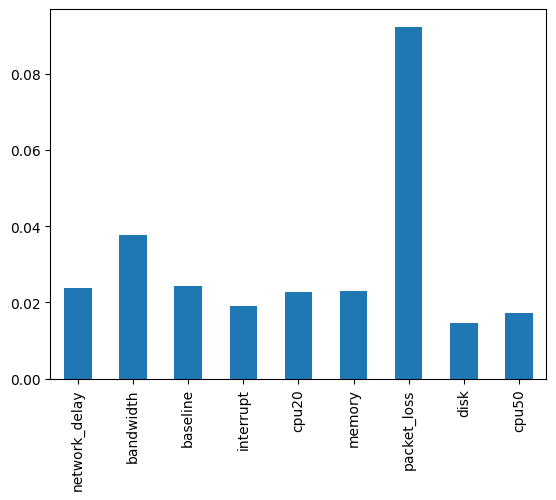

In [17]:
overview.T.mean().plot(kind="bar")

<Axes: >

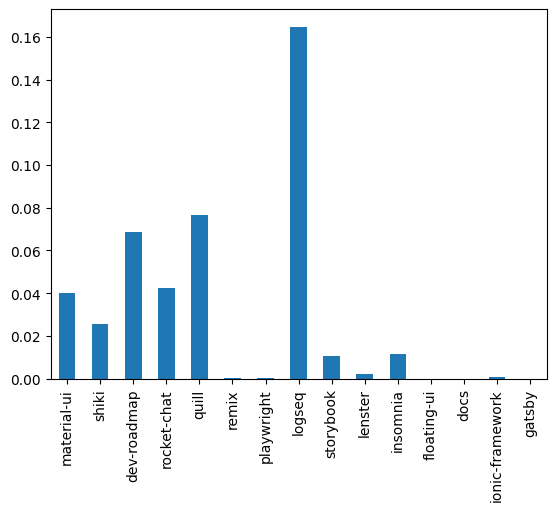

In [18]:
overview.mean().plot(kind="bar")

# Single Analysis of each Project

## Logseq

<Axes: >

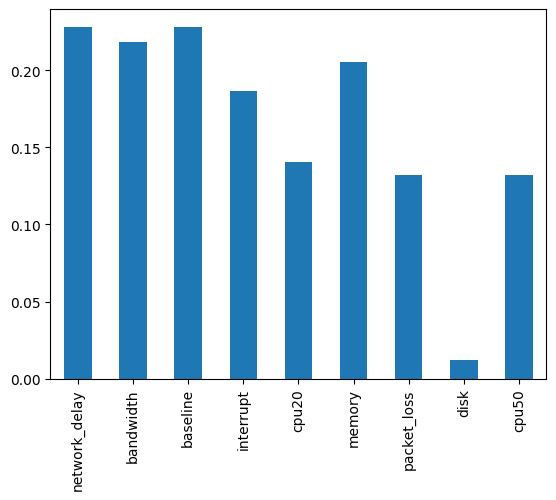

In [19]:
overview["logseq"].T.plot(kind="bar")

In [20]:
results_dict[("logseq", "baseline")].test_df

,test_name,PASSED,FAILED,SKIPPED,TOTAL RUNS,flakyness
0,/accessibility.spec.ts/should not have any aut...,20,0,0,20,0.00
1,"/basic.spec.ts/create page and blocks, save to...",20,0,0,20,0.00
2,/basic.spec.ts/delete and backspace,19,1,0,20,0.05
3,/basic.spec.ts/selection,20,0,0,20,0.00
4,/basic.spec.ts/template,20,0,0,20,0.00
...,...,...,...,...,...,...
158,/window.spec.ts/window should not be maximized...,20,0,0,20,0.00
159,/window.spec.ts/window should be maximized and...,20,0,0,20,0.00
160,/window.spec.ts/window should be restored and ...,20,0,0,20,0.00
161,/window.spec.ts/window controls should be hidd...,20,0,0,20,0.00


"whiteboard.spec.ts/Create an empedded page" Code:
```typescript
test('Create an embedded page', async ({ page }) => {
  const canvas = await page.waitForSelector('.logseq-tldraw')
  await canvas.dblclick({
    position: {
      x: 150,
      y: 150,
    },
  })

  const quickAdd$ = page.locator('.tl-quick-search')
  await expect(quickAdd$).toBeVisible()

  await page.fill('.tl-quick-search input', 'My page')
  await quickAdd$
    .locator('div[data-index="1"] .tl-quick-search-option')
    .first()
    .click()

  await expect(quickAdd$).toBeHidden()
  await expect(page.locator('.tl-logseq-portal-header a')).toContainText('My page')
})
```

Flaknyess from the dblclick function? - unlikely this function is flaky as well:
```typescript
test('undo the group deletion', async ({ page }) => {
  await page.keyboard.press(modKey + '+z')

  await expect(page.locator('.logseq-tldraw .tl-group-container')).toHaveCount(1)
  await expect(page.locator('.logseq-tldraw .tl-box-container')).toHaveCount(2)
})
```

,test_name,PASSED,FAILED,SKIPPED,TOTAL RUNS,flakyness
0,/accessibility.spec.ts/should not have any aut...,1,52,0,53,0.981132
1,"/basic.spec.ts/create page and blocks, save to...",1,52,0,53,0.981132
2,/basic.spec.ts/delete and backspace,1,0,52,1,0.000000
3,/basic.spec.ts/selection,0,1,52,1,0.000000
4,/basic.spec.ts/template,0,1,52,1,0.000000
...,...,...,...,...,...,...
158,/window.spec.ts/window should not be maximized...,0,53,0,53,0.000000
159,/window.spec.ts/window should be maximized and...,0,0,53,0,0.000000
160,/window.spec.ts/window should be restored and ...,0,0,53,0,0.000000
161,/window.spec.ts/window controls should be hidd...,0,0,53,0,0.000000
